In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.metrics import (roc_curve, auc, roc_auc_score, 
                             precision_recall_fscore_support)
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     KFold, StratifiedKFold, cross_val_score, 
                                     cross_val_predict)
from sklearn.preprocessing import label_binarize, LabelEncoder, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import (SelectKBest, f_classif, VarianceThreshold, 
                                       SelectFromModel)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import load_iris
import itertools

from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import copy

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


# OvO and OvR prediction function

In [15]:
def split_classes(X, y):
    return {
        (c1, c2): (X[(y == c1) | (y == c2)], y[(y == c1) | (y == c2)])
        for c1, c2 in itertools.combinations(np.unique(y), 2)
    }


def ovo_and_ova_multiclass_auc(X, y, base_clf, p_grid, random_state):
    results = {}
    le = LabelEncoder()
    y = le.fit_transform(y)
    class_names = le.classes_

    # Stratified K-Folds
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    ####################
    # One-vs-Rest Classification
    ####################
    print("Performing One vs Rest classification")
    ovr_clf = GridSearchCV(
        estimator=OneVsRestClassifier(base_clf),
        param_grid=p_grid,
        cv=inner_cv,
        scoring="roc_auc_ovr",
    )
    y_score = cross_val_predict(ovr_clf, X, y, cv=outer_cv, method="predict_proba")

    # Calculate AUC for each class
    y_bin = LabelBinarizer().fit_transform(y)
    ovr_auc = roc_auc_score(y_bin, y_score, multi_class="ovr", average=None)
    for idx, auc_val in enumerate(ovr_auc):
        print(f"AUC for class '{class_names[idx]}': {auc_val:.4f}")
        results[f"{class_names[idx]} vs Rest - AUC"] = auc_val

    # Calculate precision, recall, F1, and MCC for each class in OvR
    y_pred_ovr = np.argmax(y_score, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred_ovr, average=None
    )
    for idx in range(len(class_names)):
        results[f"{class_names[idx]} vs Rest - Precision"] = precision[idx]
        results[f"{class_names[idx]} vs Rest - Recall"] = recall[idx]
        results[f"{class_names[idx]} vs Rest - F1"] = f1[idx]

        # Calculate MCC for each class in OvR
        mcc = matthews_corrcoef(y, (y_pred_ovr == idx).astype(int))
        results[f"{class_names[idx]} vs Rest - MCC"] = mcc

    # Calculate macro AUC, precision, recall, F1, and MCC for OvR
    macro_ovr_auc = roc_auc_score(y_bin, y_score, multi_class="ovr", average="macro")
    macro_ovr_precision = np.mean(precision)
    macro_ovr_recall = np.mean(recall)
    macro_ovr_f1 = np.mean(f1)
    macro_ovr_mcc = np.mean(
        [
            matthews_corrcoef(y, (y_pred_ovr == idx).astype(int))
            for idx in range(len(class_names))
        ]
    )

    results["OvR Macro AUC"] = macro_ovr_auc
    results["OvR Macro Precision"] = macro_ovr_precision
    results["OvR Macro Recall"] = macro_ovr_recall
    results["OvR Macro F1"] = macro_ovr_f1
    results["OvR Macro MCC"] = macro_ovr_mcc

    print(f"Macro AUC (OvR): {macro_ovr_auc:.4f}")
    print(f"Macro Precision (OvR): {macro_ovr_precision:.4f}")
    print(f"Macro Recall (OvR): {macro_ovr_recall:.4f}")
    print(f"Macro F1 (OvR): {macro_ovr_f1:.4f}")
    print(f"Macro MCC (OvR): {macro_ovr_mcc:.4f}")

    ####################
    # One-vs-One Classification
    ####################
    print("Performing One vs One classification")
    ovo_auc = {}
    ovo_precision = {}
    ovo_recall = {}
    ovo_f1 = {}
    ovo_mcc = {}
    class_pairs = split_classes(X, y)

    for (c1, c2), (X_subset, y_subset) in class_pairs.items():
        ovo_clf = GridSearchCV(
            estimator=base_clf,
            param_grid={k.replace("estimator__", ""): v for k, v in p_grid.items()},
            cv=inner_cv,
            scoring="roc_auc",
        )
        y_score = cross_val_predict(
            ovo_clf, X_subset, y_subset, cv=outer_cv, method="predict_proba"
        )
        y_binary = (y_subset == c2).astype(int)
        fpr, tpr, _ = roc_curve(y_binary, y_score[:, 1])
        auc_val = auc(fpr, tpr)

        # Compute precision, recall, F1, and MCC for each class pair (OvO)
        y_pred_ovo = np.argmax(y_score, axis=1)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_binary, y_pred_ovo, average="binary"
        )

        # MCC for each class pair (OvO)
        mcc = matthews_corrcoef(y_binary, y_pred_ovo)

        results[
            f"{le.inverse_transform([c1])[0]} vs {le.inverse_transform([c2])[0]} - AUC"
        ] = auc_val
        results[
            f"{le.inverse_transform([c1])[0]} vs {le.inverse_transform([c2])[0]} - Precision"
        ] = precision
        results[
            f"{le.inverse_transform([c1])[0]} vs {le.inverse_transform([c2])[0]} - Recall"
        ] = recall
        results[
            f"{le.inverse_transform([c1])[0]} vs {le.inverse_transform([c2])[0]} - F1"
        ] = f1
        results[
            f"{le.inverse_transform([c1])[0]} vs {le.inverse_transform([c2])[0]} - MCC"
        ] = mcc

        ovo_auc[(c1, c2)] = auc_val
        ovo_precision[(c1, c2)] = precision
        ovo_recall[(c1, c2)] = recall
        ovo_f1[(c1, c2)] = f1
        ovo_mcc[(c1, c2)] = mcc

    # Calculate macro AUC, precision, recall, F1, and MCC for OvO
    macro_ovo_auc = np.mean(
        list(ovo_auc.values())
    )  # Macro: Average AUC over all class pairs
    macro_ovo_precision = np.mean(list(ovo_precision.values()))
    macro_ovo_recall = np.mean(list(ovo_recall.values()))
    macro_ovo_f1 = np.mean(list(ovo_f1.values()))
    macro_ovo_mcc = np.mean(list(ovo_mcc.values()))

    results["OvO Macro AUC"] = macro_ovo_auc
    results["OvO Macro Precision"] = macro_ovo_precision
    results["OvO Macro Recall"] = macro_ovo_recall
    results["OvO Macro F1"] = macro_ovo_f1
    results["OvO Macro MCC"] = macro_ovo_mcc

    print(f"Macro AUC (OvO): {macro_ovo_auc:.4f}")
    print(f"Macro Precision (OvO): {macro_ovo_precision:.4f}")
    print(f"Macro Recall (OvO): {macro_ovo_recall:.4f}")
    print(f"Macro F1 (OvO): {macro_ovo_f1:.4f}")
    print(f"Macro MCC (OvO): {macro_ovo_mcc:.4f}")

    return results


def repeat_clf(n_seeds, ks, X, y, model, sampling_strategy):

    print(ks)
    print(n_seeds)

    # Define sampling strategies
    sampling_strategies = {
        "No Sampling": None,
        "Random OverSampling": RandomOverSampler(random_state=42),
        "SMOTE": SMOTE(random_state=42),
        "Random UnderSampling": RandomUnderSampler(random_state=42),
        "NearMiss (v1)": NearMiss(version=1),
        "NearMiss (v2)": NearMiss(version=2),
        "NearMiss (v3)": NearMiss(version=3),
    }

    # If the selected strategy is not in the dictionary, use "No Sampling"
    sampler = sampling_strategies.get(sampling_strategy, None)

    seed_results = {}

    for seed in range(n_seeds):

        ks_results = {}
        for k in ks:

            print(f"CV for seed {seed} and {k} features")

            # Create a Random Forest Classifier
            rf = RandomForestClassifier(random_state=seed)

            # Create a SelectFromModel using the Random Forest Classifier
            selector = SelectFromModel(rf, max_features=k)

            if model == "rf":
                ml_model = rf
                ml_model_grid = {
                    "estimator__classification__n_estimators": [
                        100
                    ],  # Number of trees in the forest
                    "estimator__classification__max_features": [
                        "sqrt"
                    ],  # Feature selection strategy
                    "estimator__classification__criterion": [
                        "entropy"
                    ],  # Split criterion
                    "estimator__classification__min_samples_leaf": [
                        3
                    ],  # Minimum samples per leaf
                }
            elif model == "xgb":
                ml_model = XGBClassifier(
                    use_label_encoder=False, eval_metric="logloss", random_state=seed
                )
                ml_model_grid = {
                    "estimator__classification__n_estimators": [100],
                    "estimator__classification__gamma": [0],
                    "estimator__classification__max_depth": [6],
                }
            elif model == "etc":
                ml_model = ExtraTreesClassifier(random_state=seed)
                ml_model_grid = {
                    "estimator__classification__n_estimators": [100],
                }
            elif model == "lgbm":
                ml_model = LGBMClassifier(random_state=seed, verbose=-1)
                ml_model_grid = {
                    "estimator__classification__n_estimators": [100],
                }

            # If there is a sampler, include it in the pipeline
            steps = []
            if sampler:
                steps.append(("sampling", sampler))
            steps.append(("feature_selection", selector))
            steps.append(("classification", ml_model))

            # Create a pipeline with feature selection, sampling, and classification
            pipeline = Pipeline(steps=steps)

            ###########################

            # Run the classification with the sampling strategy
            results = ovo_and_ova_multiclass_auc(
                X, y, pipeline, ml_model_grid, random_state=seed
            )

            print(results)

             ks_results[k] = {
                "results": results,
                "Dataset": X,
                "Model": model,
                "Sampling_Strategy": sampling_strategy,
            }


        seed_results[seed] = copy.copy(ks_results)

    return seed_results

def store_results(seed_results, output):

   ''' # Flatten the nested dictionary into a DataFrame
    df = pd.DataFrame(
        {
            (outer_key, inner_key): values
            for outer_key, inner_dict in seed_results.items()
            for inner_key, values in inner_dict.items()
        }
    ).T'''

   final_results = []
    
    for seed, ks_results in seed_results.items():
        for k, result_info in ks_results.items():
            result = result_info["results"]
            model = result_info["Model"]
            sampling_strategy = result_info["Sampling_Strategy"]
            dataset=result_info["Dataset"]
            
            # Collect all relevant information in a list
            final_results.append({
                "Seed": seed,
                "Features (k)": k,
                "Dataset":dataset,
                "Model": model,
                "Sampling Strategy": sampling_strategy,
                "Result": result,  # Assuming 'result' contains the results of your classification
            })
    df = pd.DataFrame(final_results)

    #Set multi-level index names for clarity
    df.set_index(["Seed", "Features (k)", "Dataset", "Model", "Sampling Strategy"], inplace=True)

    df.index.names = ["Seed", "Features (k)","Dataset","Model","Sampling Strategy"]
    # Display the DataFrame
     df = df.reset_index()


    df.to_csv(output, mode='a', header=not os.path.exists(output))

    print(df)

def run_classification(X, y, ks, n_seeds,output,model, sampling_strategy):

    # Ensure ks does not exceed the number of columns in X
    max_features = len(X.columns)
    ks = [k for k in ks if k <= max_features]
    if max_features not in ks:
        ks.append(max_features)

    seed_results = repeat_clf(n_seeds, ks, X, y, model, sampling_strategy)
    store_results(seed_results, output)


# Test multiclass dataset to evaluate the function

In [11]:
from sklearn.datasets import make_classification
import pandas as pd

# Generate a synthetic dataset
X, y = make_classification(
    n_samples=150,      # Number of samples
    n_features=1000,    # Total number of features
    n_informative=20,   # Number of informative features
    n_redundant=200,    # Number of redundant features
    n_classes=3,        # Number of target classes
    weights=[0.7, 0.2, 0.1],  # Proportion for each class
    random_state=42     # For reproducibility
)

# Convert to DataFrame
X = pd.DataFrame(X)
y = pd.Series(y, name="target")

# Display class distribution
print(y.value_counts())


target
0    105
1     31
2     14
Name: count, dtype: int64


In [1]:
n_seeds = 2
ks = [2]

run_classification(X, y, ks, n_seeds, "test_clf.csv")

NameError: name 'run_classification' is not defined

# Plot individual k with bar plot
## TODO remove index

   index  Seed  Features (k)  0 vs Rest  1 vs Rest  2 vs Rest  OvR Macro AUC  \
0      0     1            10   0.783492   0.837625   0.684349       0.768489   
1      1     1           100   0.808466   0.879100   0.796744       0.828103   
2      2     2            10   0.809101   0.825156   0.751050       0.795102   
3      3     2           100   0.839153   0.862564   0.792017       0.831245   
4      4     3            10   0.778201   0.829222   0.809349       0.805591   
5      5     3           100   0.813757   0.857143   0.763130       0.811343   

     0 vs 1    0 vs 2    1 vs 2  OvO Macro AUC  
0  0.834101  0.684354  0.942396       0.820284  
1  0.894624  0.819048  0.956221       0.889964  
2  0.813825  0.727551  0.923963       0.821780  
3  0.848541  0.790476  0.926267       0.855095  
4  0.826114  0.705442  0.912442       0.814666  
5  0.886329  0.754422  0.953917       0.864889  


/tmp/ipykernel_42066/387308984.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
/tmp/ipykernel_42066/387308984.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


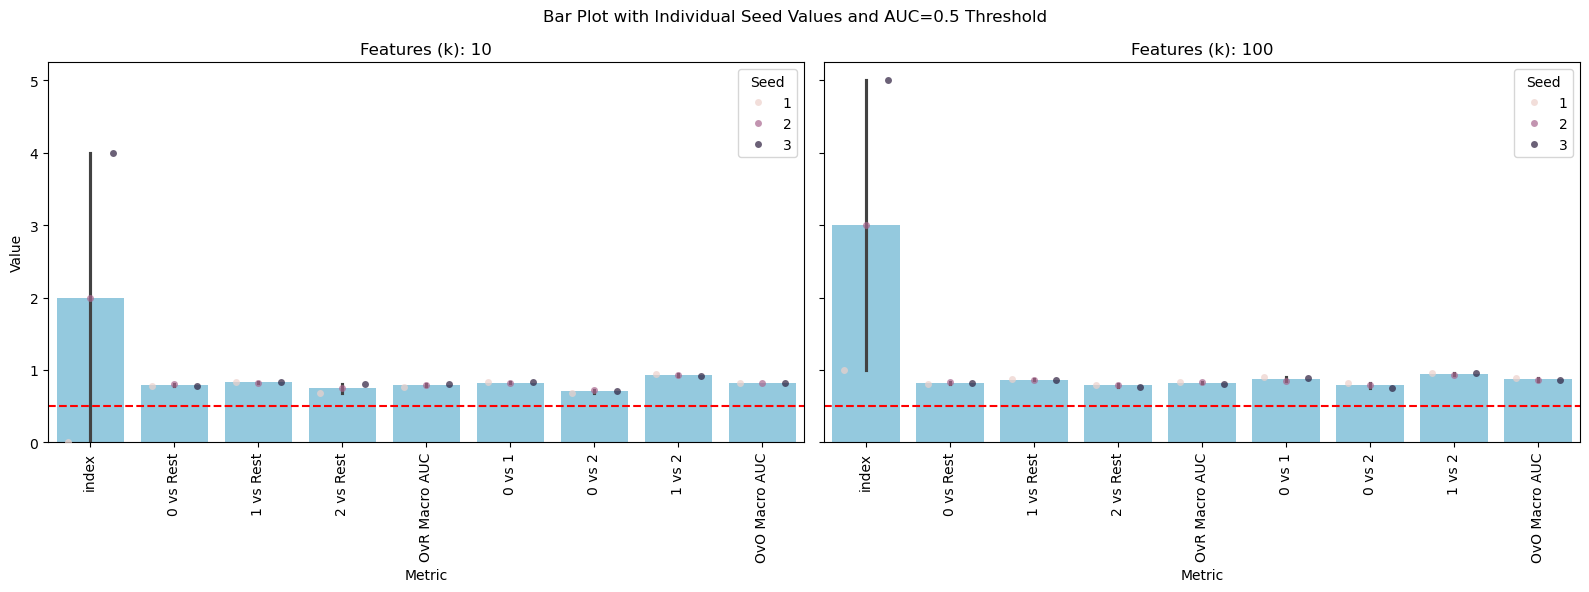

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df` is your DataFrame
# Resetting the index to simplify handling hierarchical index
df = df.reset_index()

print(df)

# Melting the dataframe to long format for seaborn compatibility
df_melted = df.melt(
    id_vars=["Seed", "Features (k)"], 
    var_name="Metric", 
    value_name="Value"
)

# Initialize the subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Iterate over the two subsets (10 and 100 features)
for i, features in enumerate([10, 100]):
    subset = df_melted[df_melted["Features (k)"] == features]

    # Plot barplot for averages with error bars
    sns.barplot(
        data=subset, 
        x="Metric", 
        y="Value", 
        ax=axes[i], 
        ci="sd", 
        color="skyblue",
        estimator="mean",
    )

    # Overlay stripplot for individual seed values
    sns.stripplot(
        data=subset, 
        x="Metric", 
        y="Value", 
        ax=axes[i], 
        hue="Seed",
        dodge=True, 
        jitter=True, 
        alpha=0.7
    )

    # Add a horizontal dashed red line for AUC = 0.5
    axes[i].axhline(0.5, color="red", linestyle="--", linewidth=1.5)

    # Set subplot title
    axes[i].set_title(f"Features (k): {features}")

    # Rotate x-axis labels for clarity
    axes[i].tick_params(axis='x', rotation=90)

# Set overall title and adjust layout
fig.suptitle("Bar Plot with Individual Seed Values and AUC=0.5 Threshold")
fig.tight_layout()
plt.show()


#  Plot all k for all modes

/tmp/ipykernel_430192/1018015526.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap("tab10", len(ovr_metrics))  # Tab10 colormap for 4 colors


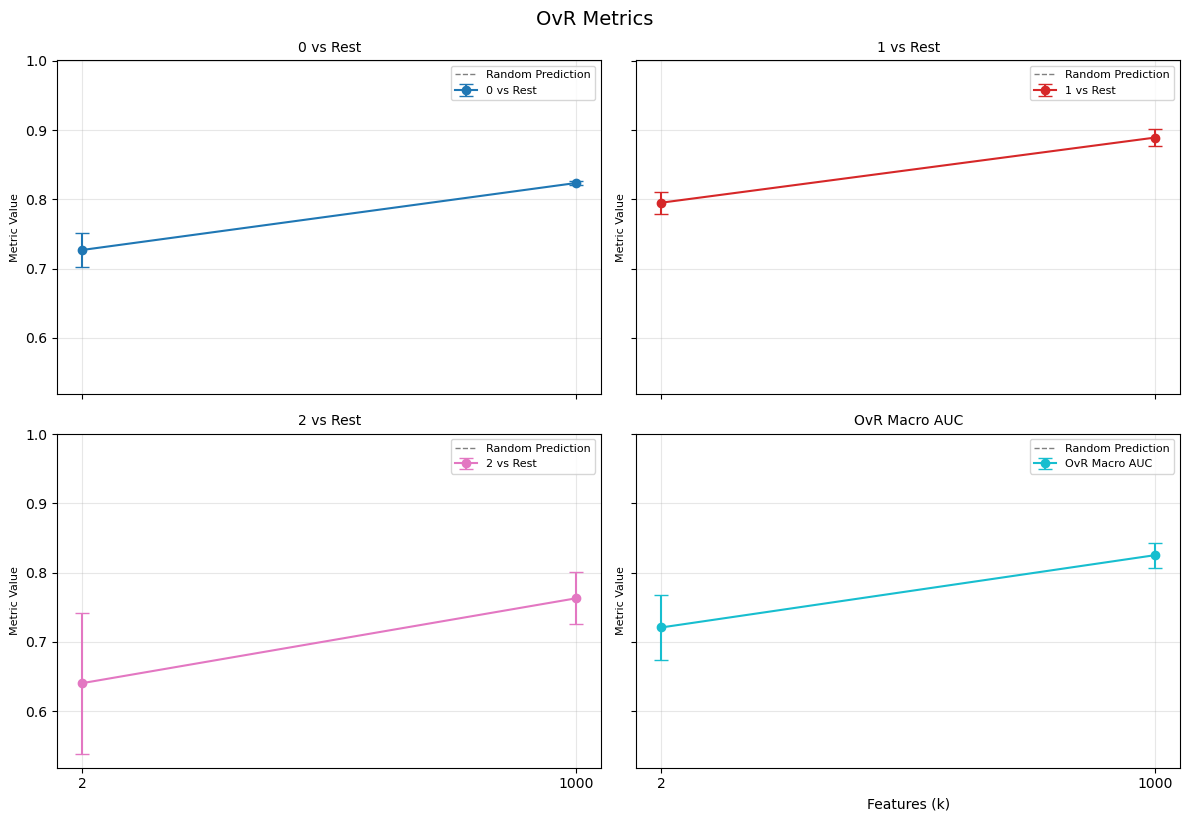

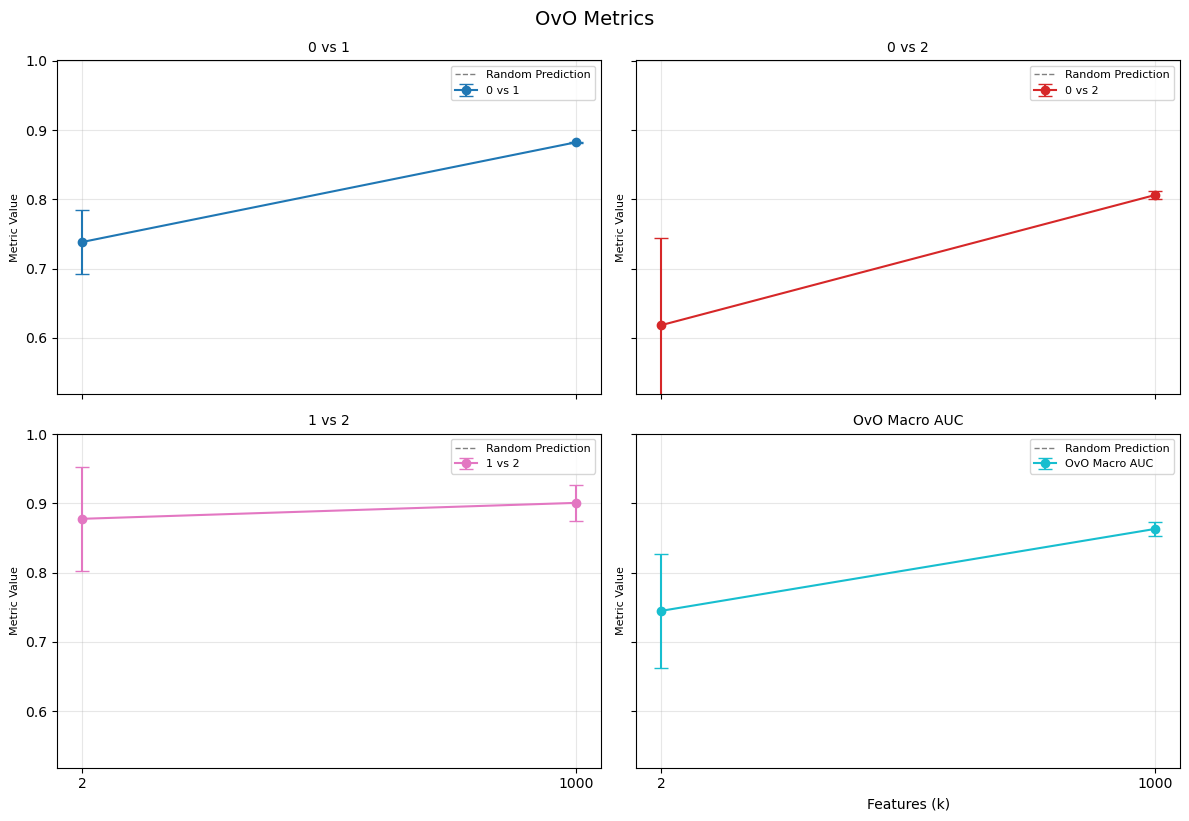

In [5]:
df = pd.read_csv("test_clf.csv", index_col = 0)
# print(df.head())


# Group by 'Features (k)' and calculate mean and std for each metric
metrics = df.columns[2:]  # All columns after 'Seed' and 'Features (k)'
summary = df.groupby("Features (k)").agg(["mean", "std"])

# Map 'Features (k)' to evenly spaced indices
features = summary.index
x_indices = range(len(features))

# Separate OvR and OvO metrics
ovr_metrics = ["0 vs Rest","1 vs Rest","2 vs Rest", "OvR Macro AUC"]
ovo_metrics = ["0 vs 1","0 vs 2","1 vs 2", "OvO Macro AUC"]

# Find the y-axis range for all metrics
y_min = min(summary[(metric, "mean")].min() for metric in metrics) - 0.1
y_max = max(summary[(metric, "mean")].max() for metric in metrics) + 0.1

# Generate a colormap
color_map = cm.get_cmap("tab10", len(ovr_metrics))  # Tab10 colormap for 4 colors

# Plot OvR metrics
fig_ovr, axes_ovr = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes_ovr = axes_ovr.flatten()

for i, (ax, metric) in enumerate(zip(axes_ovr, ovr_metrics)):
    means = summary[(metric, "mean")]
    stds = summary[(metric, "std")]
    ax.errorbar(
        x_indices,
        means,
        yerr=stds,
        capsize=5,
        marker="o",
        color=color_map(i),
        label=metric,
    )
    ax.axhline(y=0.5, color="gray", linestyle="--", linewidth=1, label="Random Prediction")
    ax.set_title(f"{metric}", fontsize=10)
    ax.set_ylabel("Metric Value", fontsize=8)
    ax.grid(alpha=0.3)
    ax.legend(loc="best", fontsize=8)
    ax.set_ylim(y_min, y_max)  # Apply the same y-axis range

axes_ovr[-1].set_xticks(x_indices)
axes_ovr[-1].set_xticklabels(features)
axes_ovr[-1].set_xlabel("Features (k)", fontsize=10)

plt.tight_layout()
fig_ovr.suptitle("OvR Metrics", fontsize=14, y=1.02)
plt.show()

# Plot OvO metrics
fig_ovo, axes_ovo = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes_ovo = axes_ovo.flatten()

for i, (ax, metric) in enumerate(zip(axes_ovo, ovo_metrics)):
    means = summary[(metric, "mean")]
    stds = summary[(metric, "std")]
    ax.errorbar(
        x_indices,
        means,
        yerr=stds,
        capsize=5,
        marker="o",
        color=color_map(i),
        label=metric,
    )
    ax.axhline(y=0.5, color="gray", linestyle="--", linewidth=1, label="Random Prediction")
    ax.set_title(f"{metric}", fontsize=10)
    ax.set_ylabel("Metric Value", fontsize=8)
    ax.grid(alpha=0.3)
    ax.legend(loc="best", fontsize=8)
    ax.set_ylim(y_min, y_max)  # Apply the same y-axis range

axes_ovo[-1].set_xticks(x_indices)
axes_ovo[-1].set_xticklabels(features)
axes_ovo[-1].set_xlabel("Features (k)", fontsize=10)

plt.tight_layout()
fig_ovo.suptitle("OvO Metrics", fontsize=14, y=1.02)
plt.show()

# Load HP multiomics data


In [11]:
X_raw_1 = pd.read_csv('input/HP_multiomics/Amplicon_X.csv', sep="\t", index_col=0)
X_raw_2 = pd.read_csv('input/HP_multiomics/RNA_X.csv', sep="\t", index_col=0)
y_raw = pd.read_csv('input/HP_multiomics/metadata.csv', sep = "\t", index_col=0)

print(X_raw_1.head())
print(X_raw_2.head())
print(y_raw.head())


       ASV1      ASV2      ASV3      ASV4      ASV5      ASV6      ASV7  \
0  0.017371  0.005184  0.023717  0.009881  0.001094  0.008298  0.000000   
1  0.000088  0.252867  0.023640  0.047785  0.000088  0.016262  0.000033   
2  0.034550  0.000064  0.033724  0.004670  0.000048  0.011914  0.000032   
3  0.009198  0.002934  0.044401  0.014516  0.020535  0.011961  0.000000   
4  0.008463  0.000466  0.000111  0.010617  0.001644  0.005753  0.009818   

       ASV8      ASV9     ASV10  ...  ASV6219  ASV6220  ASV6221  ASV6222  \
0  0.000202  0.009696  0.004646  ...      0.0      0.0      0.0      0.0   
1  0.001352  0.003870  0.000044  ...      0.0      0.0      0.0      0.0   
2  0.016282  0.011501  0.003654  ...      0.0      0.0      0.0      0.0   
3  0.006151  0.002328  0.007495  ...      0.0      0.0      0.0      0.0   
4  0.000866  0.006752  0.003798  ...      0.0      0.0      0.0      0.0   

   ASV6223  ASV6224  ASV6225  ASV6226   ASV6227  ASV6228  
0      0.0      0.0      0.0     

In [16]:
# make sure X and y have same index
index_intersect = y_raw.index.intersection(X_raw_1.index)
index_intersect = X_raw_1.index.intersection(X_raw_2.index)

X_raw_1 = X_raw_1.loc[index_intersect]
X_raw_2 = X_raw_2.loc[index_intersect]

# sort index 
X_1 = X_raw_1.sort_index()
X_2 = X_raw_2.sort_index()
y_raw = y_raw.sort_index()

# Merge both features dfs
X_3 = pd.concat([X_1, X_2], axis=1)

print(X_1.shape)  
print(X_2.shape)
print(X_3.shape)
print(y_raw.shape)

y = y_raw.loc[:,"Sample Condition"]


(132, 6228)
(132, 60839)
(132, 67067)
(132, 22)
